### 2. Import the Necessary Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timezone
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import types
from sqlalchemy import text

### 2. Set-up Shopiy API Credentials

In [63]:
# Shopify API credentials
shop_url = "acalaskin.myshopify.com"
api_version = '2024-07'
access_token = 'put you access token here'
# API endpoint
base_url = f"https://{shop_url}/admin/api/{api_version}/orders.json?status=any"


### 3. Data time rage set-up

In [64]:
# Set the date range in your local time zone
start_date_local = datetime(2022, 1, 1, 0, 0, 0)
end_date_local = datetime(2024, 8, 15, 23, 59, 59)

# Convert the dates to UTC
start_date = start_date_local.astimezone(timezone.utc).isoformat()
end_date = end_date_local.astimezone(timezone.utc).isoformat()

### 4. Using the Shopify API to Retrieve the Sales data

In [65]:
# Initialize variables
order_data = []
params = {
    'created_at_min': start_date,
    'created_at_max': end_date,
    'status': 'any',
    'fulfillment_status': 'any',
    'limit': 250,
    'fields': 'id,order_number,customer,name,email,financial_status,processed_at,fulfillment_status,currency,subtotal_price,total_shipping_price_set,total_tax,total_price,shipping_lines,created_at,line_items,shipping_address,payment_gateway_names,cancel_reason,refunds,current_total_discounts',
}

while True:
    response = requests.get(base_url, headers={
        'X-Shopify-Access-Token': access_token
    }, params=params)
    
    if response.status_code == 200:
        orders = response.json().get('orders', [])
        if not orders:
            break

        # Process orders
        for order in orders:
            shipping_address = order.get('shipping_address', {})
            # transaction = order.get('transaction', {})
            for line_item in order.get('line_items', []):
                order_data.append({
                    'Order Number': order.get('order_number'),
                    'Customer Name': f"{order.get('customer', {}).get('first_name', '')} {order.get('customer', {}).get('last_name', '')}",
                    'Customer Email': order.get('email'),
                    'Financial Status': order.get('financial_status'),
                    'Paid At': order.get('processed_at'),
                    'Fulfillment Status': order.get('fulfillment_status'),
                    'Currency': order.get('currency'),
                    'Subtotal': order.get('subtotal_price'),
                    'Shipping': order.get('total_shipping_price_set', {}).get('shop_money', {}).get('amount'),
                    'Taxes': order.get('total_tax'),
                    'Total': order.get('total_price'),
                    'Shipping Method': ', '.join([shipping_line.get('title') for shipping_line in order.get('shipping_lines', [])]),
                    'Created At': order.get('created_at'),
                    'Lineitem Quantity': line_item.get('quantity'),
                    'Lineitem Name': line_item.get('name'),
                    'Lineitem Price': line_item.get('price'),
                    'Lineitem SKU': line_item.get('sku'),
                    'Shipping City': shipping_address.get('city', 'N/A') if shipping_address else 'N/A',
                    'Shipping Province': shipping_address.get('province', 'N/A') if shipping_address else 'N/A',
                    'Payment Methods': order.get('payment_gateway_names'),
                    'cancel_reason': order.get('cancel_reason'),
                    # 'Refunds': order.get('refunds'),
                    'Discounts': order.get('current_total_discounts'),

                })

        # Pagination: Check if there is a next page
        if 'next' in response.links.keys():
            base_url = response.links['next']['url']
            params = {}  # Clear params for the next page URL
        else:
            break
    else:
        print(f"Error fetching orders: {response.status_code} - {response.text}")
        break

# Convert to DataFrame
df_orders = pd.DataFrame(order_data)

# Inspect DataFrame
df_orders.head()


,Order Number,Customer Name,Customer Email,Financial Status,Paid At,Fulfillment Status,Currency,Subtotal,Shipping,Taxes,Total,Shipping Method,Created At,Lineitem Quantity,Lineitem Name,Lineitem Price,Lineitem SKU,Shipping City,Shipping Province,Payment Methods,cancel_reason,Discounts
0,4573,Amanda Hernández,amanda.hernandez.cedillo@gmail.com,pending,2024-08-15T23:50:40-06:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T23:50:40-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,,Tlalpan,Ciudad de México,[Cash on Delivery (COD)],None,0.00
1,4572,Silvia Maldonado,sm0982866@gmail.com,pending,2024-08-15T21:34:21-06:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T21:34:21-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,,Coacalco de Berriozabal,México,[Cash on Delivery (COD)],None,0.00
2,4571,Norma Carrillo,angelicacarrillo2115@gmail.com,pending,2024-08-15T21:08:37-06:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T21:08:37-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,,Toluca,México,[Cash on Delivery (COD)],None,0.00
3,4570,Guadalupe García Rosales,guadaluperosales151279@gmail.com,pending,2024-08-15T15:38:33-06:00,None,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T15:38:33-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,,Nicolas Romero,México,[Cash on Delivery (COD)],None,0.00
4,4569,Claudia muñoz,ivettcita20@gmail.com,pending,2024-08-15T13:48:01-06:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T13:48:01-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,,Gustavo A. Madero,Ciudad de México,[Cash on Delivery (COD)],None,0.00


### 5. Check data columns

In [66]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4364 entries, 0 to 4363
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Order Number        4364 non-null   int64 
 1   Customer Name       4364 non-null   object
 2   Customer Email      4364 non-null   object
 3   Financial Status    4364 non-null   object
 4   Paid At             4364 non-null   object
 5   Fulfillment Status  2433 non-null   object
 6   Currency            4364 non-null   object
 7   Subtotal            4364 non-null   object
 8   Shipping            4364 non-null   object
 9   Taxes               4364 non-null   object
 10  Total               4364 non-null   object
 11  Shipping Method     4364 non-null   object
 12  Created At          4364 non-null   object
 13  Lineitem Quantity   4364 non-null   int64 
 14  Lineitem Name       4364 non-null   object
 15  Lineitem Price      4364 non-null   object
 16  Lineitem SKU        4364

### 6. Create 2 new columns to Identify unique orders and Province name normalization

In [67]:
# Step 1: Create a boolean mask to identify the first occurrence of each 'Order Number'
first_occurrence_mask = ~df_orders.duplicated(subset=['Order Number'], keep='first')

# Step 2: Create 'Unique Total' where only the first occurrence keeps the 'Total' value, others get 0
df_orders['Unique Total'] = df_orders['Total'].where(first_occurrence_mask, 0)

# Step 3: Create a boolean mask for the rows that meet the criteria for an order thatt should be counted as one.
condition = (df_orders['Financial Status'].isin(['paid', 'pending'])) & (df_orders['cancel_reason'].isna() | (df_orders['cancel_reason'] == ''))

# Step 4: Initialize 'Unique Net Total' with NaN values
df_orders['Unique Net Total'] = pd.NA

# Step 5: Populate 'Unique Net Total' with values from 'Unique Total' where conditions are met
df_orders.loc[condition, 'Unique Net Total'] = df_orders.loc[condition, 'Unique Total']

# Step 6: Replace NaN values with 0 in 'Unique Net Total'
df_orders['Unique Net Total'] = df_orders['Unique Net Total'].fillna(0)

# PROVINCE NAME NORMALIZATION
# Mapping dictionary to normalize state names
state_mapping = {
    "Ciudad de México": "Ciudad de México",
    "México": "Estado de México",
    "Estado de México": "Estado de México",
    "Edo mexico": "Estado de México",
    "Eso.de Mexico": "Estado de México",
    "De estado de mexico": "Estado de México",
    "Estado mexico": "Estado de México",
    "EDO. MEX.": "Estado de México",
    "De México": "Estado de México",
    "De Mexico": "Estado de México",
    "Ecatepec": "Estado de México",
    "D.F": "Ciudad de México",
    "Querétaro": "Querétaro",
    "QRO.": "Querétaro",
    "Nuevo León": "Nuevo León",
    "N.L.": "Nuevo León",
    "NL": "Nuevo León",
    "NL ": "Nuevo León",
    "N. L": "Nuevo León",
    "Baja California Sur": "Baja California Sur",
    "Baja California": "Baja California",
    "Veracruz": "Veracruz",
    "VER.": "Veracruz",
    "Hidalgo": "Hidalgo",
    "HGO.": "Hidalgo",
    "Puebla": "Puebla",
    "Amozoc.puebla": "Puebla",
    "Morelos": "Morelos",
    "Guerrero": "Guerrero",
    "Guerreto": "Guerrero",
    "Michoacán": "Michoacán",
    "MICH.": "Michoacán",
    "Tlaxcala": "Tlaxcala",
    "Chihuahua": "Chihuahua",
    "CHIH.": "Chihuahua",
    "Aguascalientes": "Aguascalientes",
    "Guanajuato": "Guanajuato",
    "GTO.": "Guanajuato",
    "Jalisco": "Jalisco",
    "Nayarit": "Nayarit",
    "NAY.": "Nayarit",
    "Sinaloa": "Sinaloa",
    "Yucatán": "Yucatán",
    "Zacatecas": "Zacatecas",
    "Tabasco": "Tabasco",
    "Coahuila": "Coahuila",
    "COAH.": "Coahuila",
    "COAH,": "Coahuila",
    "San Luis Potosí": "San Luis Potosí",
    "S.l.p.": "San Luis Potosí",
    "S.L.P.": "San Luis Potosí",
    "Colima": "Colima",
    "Quintana Roo": "Quintana Roo",
    "Q. ROO": "Quintana Roo",
    "Q.roo.": "Quintana Roo",
    "Chiapas": "Chiapas",
    "Tamaulipas": "Tamaulipas",
    "Campeche": "Campeche",
    "Oaxaca": "Oaxaca",
    "OAX.": "Oaxaca",
    "Durango": "Durango",
    "Sonora": "Sonora",
    "Leon": "Guanajuato",
    "Tultitlán": "Estado de México",
    "Tijuana": "Baja California",
    "B.C.": "Baja California",
}

# Apply the mapping and replace non-mapped states with 'Estado de México'
df_orders['Shipping Province'] = df_orders['Shipping Province'].replace(state_mapping)

# For any state that wasn't mapped (non-recognized values), replace with 'Estado de México'
df_orders['Shipping Province'] = df_orders['Shipping Province'].apply(lambda x: x if x in state_mapping.values() else "Estado de México")


# Save the cleaned DataFrame
df_orders.to_csv('shopify_orders_2024_cleanednames.csv', index=False, encoding='utf-8-sig')
print("Data retrieved and saved to 'shopify_orders_2024_cleanednames.csv'")


Data retrieved and saved to 'shopify_orders_2024_cleanednames.csv'


### 7. Data cleaning for Payment Method column

In [68]:
# Convert the Payment Methods column to strings, handling non-string values
df_orders['Payment Methods'] = df_orders['Payment Methods'].astype(str)

# Remove only braces (parentheses and brackets) from the Payment Methods column
df_orders['Payment Methods'] = df_orders['Payment Methods'].str.replace(r'[()\[\]{}]', "", regex=True)

# Remove single quotes if they are part of the string data
df_orders['Payment Methods'] = df_orders['Payment Methods'].str.replace("'", "", regex=False)

# Inspect the Payment Methods column after cleaning
print(df_orders['Payment Methods'])

0       Cash on Delivery COD
1       Cash on Delivery COD
2       Cash on Delivery COD
3       Cash on Delivery COD
4       Cash on Delivery COD
                ...         
4359                  stripe
4360                  paypal
4361                  stripe
4362                  stripe
4363                  stripe
Name: Payment Methods, Length: 4364, dtype: object


### 8. Data cleaning (Find null values)

In [69]:
# Get column names and corresponding count of null values
null_columns = {}
for col in df_orders.columns:
    null_count = df_orders[col].isnull().sum()
    if null_count > 0:
        null_columns[col] = null_count
        
print("Columns with null values and their counts:")
print(null_columns)        

Columns with null values and their counts:
{'Fulfillment Status': 1931, 'cancel_reason': 3477}


### 9. Data cleaning (Replace empty strings and null values to 0)

In [70]:
# Replace empty strings or spaces with NaN
df_orders['Lineitem SKU'] = df_orders['Lineitem SKU'].replace(r'^\s*$', np.nan, regex=True)

#Convert null values to 0
df_orders = df_orders.fillna('N/A')
#Check
null_columns = {}
for col in df_orders.columns:
    null_count = df_orders[col].isnull().sum()
    if null_count > 0:
        null_columns[col] = null_count
        
print("Columns with null values and their counts:")
print(null_columns)

Columns with null values and their counts:
{}


### 10. Normalization for product name column

In [71]:
# Normalization dictionary for product name column
normalizacion_nombres = {
    'Super Serum 4 en 1 Acala Skin': [
        'Acala Skin - Super Serum 4 en 1',
        'Super Serum 4 en 1 Acala Skin',
        'Super Serum 4 en 1 Vitamina C'
    ],
    'Kit de Pestañas Magnéticas': [
        'Kit de Pestañas Magnéticas',
        'Kit de Pestañás Magnéticas',
        'Kit de Pestañas Magnéticas Premium'
    ]
}

# Normalization function
def normalizar_nombre(nombre):
    for nombre_estandar, variantes in normalizacion_nombres.items():
        if nombre in variantes:
            return nombre_estandar
    return nombre  # Retorna el nombre original si no hay coincidencia

# Apply normalization
df_orders['Lineitem Name'] = df_orders['Lineitem Name'].apply(normalizar_nombre)

# Normalization dictionary for payment method
normalizacion_metodos_pago = {
    'PayPal': [
        'paypal',
        'PayPal Express Checkout',
        'stripe, paypal'
    ],
    'Stripe': [
        'stripe',
        'Stripe Card Payments'
    ]
}

# Normalization function
def normalizar_metodo_pago(metodo):
    if pd.isna(metodo) or metodo.strip() == '':
        return 'Cash on Delivery COD'
    
    for metodo_estandar, variantes in normalizacion_metodos_pago.items():
        if metodo in variantes:
            return metodo_estandar
    return metodo  # Retorna el método original si no hay coincidencia

# Apply normalization and fill in blanks
df_orders['Payment Methods'] = df_orders['Payment Methods'].apply(normalizar_metodo_pago)

# # Check results
# df_orders.to_csv('shopify_orders_2024_cleanednames.csv', index=False, encoding= 'utf-8-sig')
# print("Data retrieved and saved to 'fshopify_orders_2024_cleaned.csv")


### 11. Change format for Paid At column

In [72]:
# Convert 'Paid At' to datetime, including timezone information
df_orders['Paid At'] = pd.to_datetime(df_orders['Paid At'], utc=True)
df_orders.head()

,Order Number,Customer Name,Customer Email,Financial Status,Paid At,Fulfillment Status,Currency,Subtotal,Shipping,Taxes,Total,Shipping Method,Created At,Lineitem Quantity,Lineitem Name,Lineitem Price,Lineitem SKU,Shipping City,Shipping Province,Payment Methods,cancel_reason,Discounts,Unique Total,Unique Net Total
0,4573,Amanda Hernández,amanda.hernandez.cedillo@gmail.com,pending,2024-08-16 05:50:40+00:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T23:50:40-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,N/A,Tlalpan,Ciudad de México,Cash on Delivery COD,N/A,0.00,449.00,449.00
1,4572,Silvia Maldonado,sm0982866@gmail.com,pending,2024-08-16 03:34:21+00:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T21:34:21-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,N/A,Coacalco de Berriozabal,Estado de México,Cash on Delivery COD,N/A,0.00,449.00,449.00
2,4571,Norma Carrillo,angelicacarrillo2115@gmail.com,pending,2024-08-16 03:08:37+00:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T21:08:37-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,N/A,Toluca,Estado de México,Cash on Delivery COD,N/A,0.00,449.00,449.00
3,4570,Guadalupe García Rosales,guadaluperosales151279@gmail.com,pending,2024-08-15 21:38:33+00:00,N/A,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T15:38:33-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,N/A,Nicolas Romero,Estado de México,Cash on Delivery COD,N/A,0.00,449.00,449.00
4,4569,Claudia muñoz,ivettcita20@gmail.com,pending,2024-08-15 19:48:01+00:00,fulfilled,MXN,449.00,0.00,0.00,449.00,Envío Gratis - Pago en Línea,2024-08-15T13:48:01-06:00,1,Super Serum 4 en 1 Acala Skin,449.00,N/A,Gustavo A. Madero,Ciudad de México,Cash on Delivery COD,N/A,0.00,449.00,449.00


### 12. Column prep for analysis

In [73]:
# Set 'Paid At' as the index
df_orders.set_index('Paid At', inplace=True)

# Ensure 'Total' is numeric
df_orders['Total'] = pd.to_numeric(df_orders['Total'], errors='coerce')

### 13. Monthly Sales trend

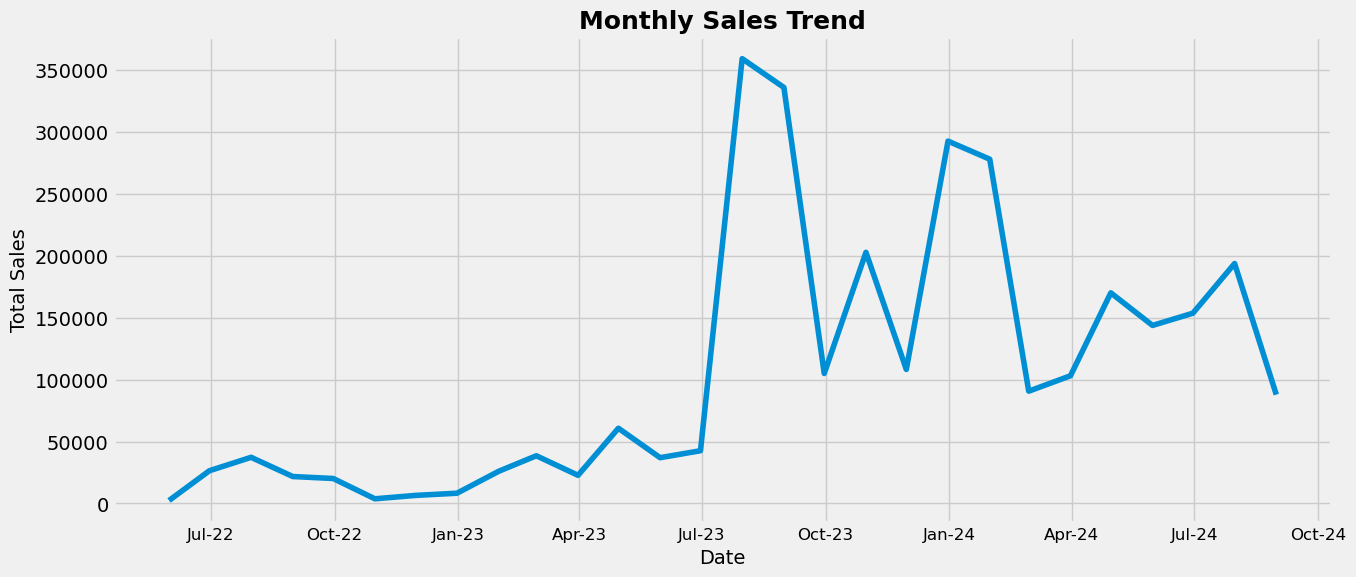

In [74]:
import matplotlib.dates as mdates

# Define a color palette
color_palette = {
    'line_color': 'orange',
    'bar_color': 'skyblue',
    'marker_color': 'blue',
    'background_color': 'lightgrey',
    'grid_color': 'gray'
}

# Apply the 'fivethirtyeight' style
plt.style.use('fivethirtyeight')

# Resample to monthly frequency and sum total sales
monthly_sales = df_orders['Total'].resample('ME').sum()

# Plotting
plt.figure(figsize=(14, 6))  # Set background color for the figure

# ax = plt.gca()  # Get the current axes
# ax.set_facecolor(color_palette['background_color'])  # Set plot area background color

# Customizing the plot
plt.plot(monthly_sales.index, monthly_sales)

# Customizing the title and labels
plt.title('Monthly Sales Trend', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

# Formatting the date on the x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.xticks(fontsize=12)

# # Customizing the plot border (spines)
# for spine in ax.spines.values():
#     spine.set_edgecolor(color_palette['background_color'])  # Set the color of the spines
#     spine.set_linewidth(1)  # Optional: adjust the thickness of the spines

plt.show()






### 14. Total order amount by payment method BoxPlot

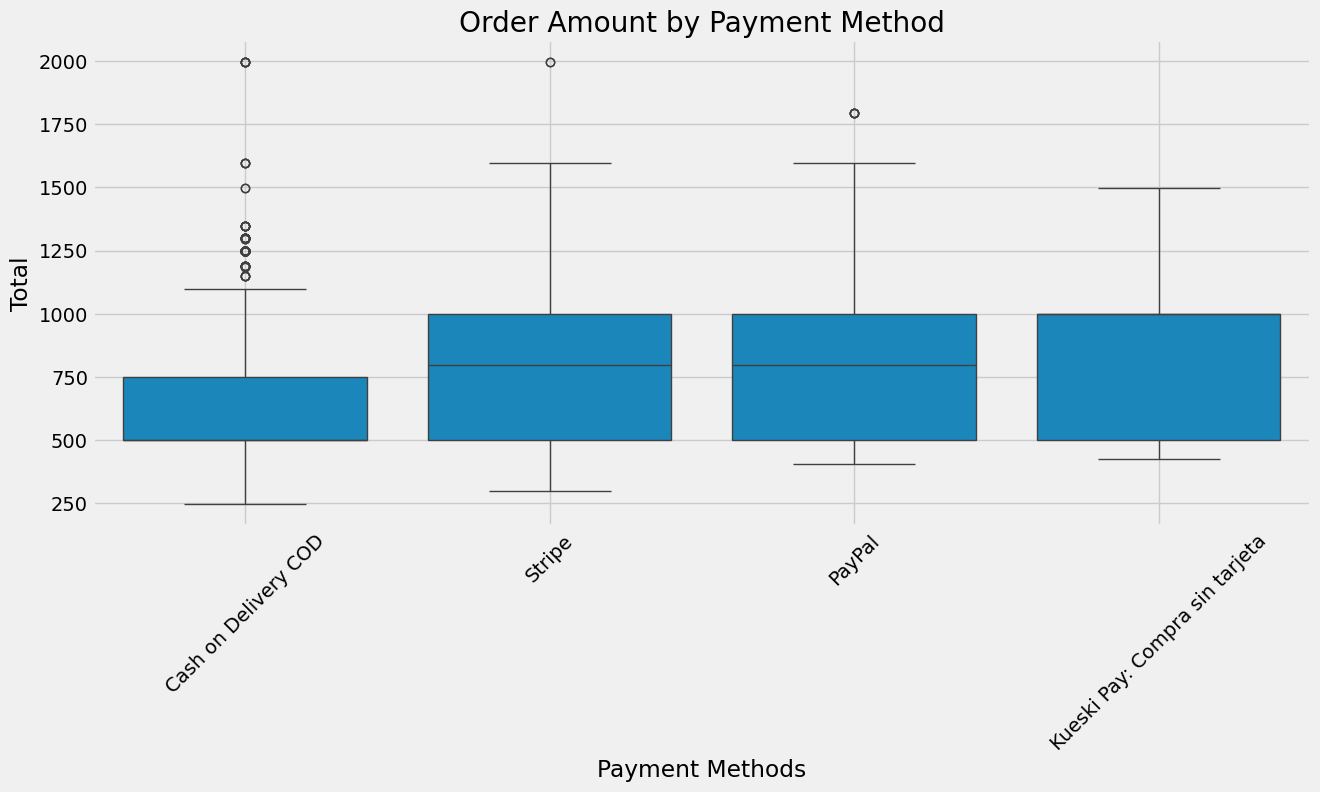

In [75]:
# Plot total order amount by payment method
plt.figure(figsize=(14, 6))
sns.boxplot(df_orders, x='Payment Methods', y='Total')
plt.title('Order Amount by Payment Method')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 15.  Boxplot to detect outliers in 'Total' column

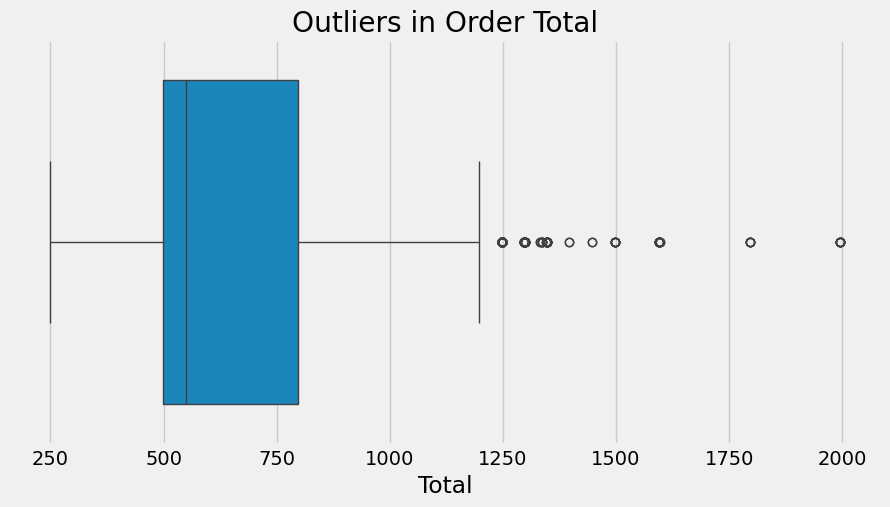

In [76]:
# Boxplot to detect outliers in 'Total' column
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_orders, x='Total')
plt.title('Outliers in Order Total')
plt.show()

### 16. Distribution of Total Sales

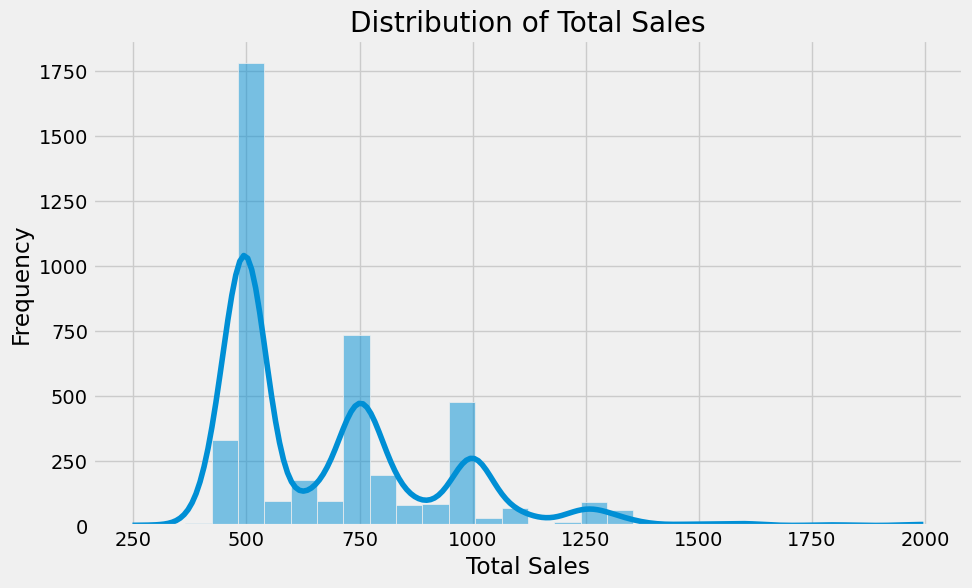

In [77]:
# Distribution of Total Sales
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['Total'].dropna(), bins=30, kde=True)
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### 17. Total sales by payment method

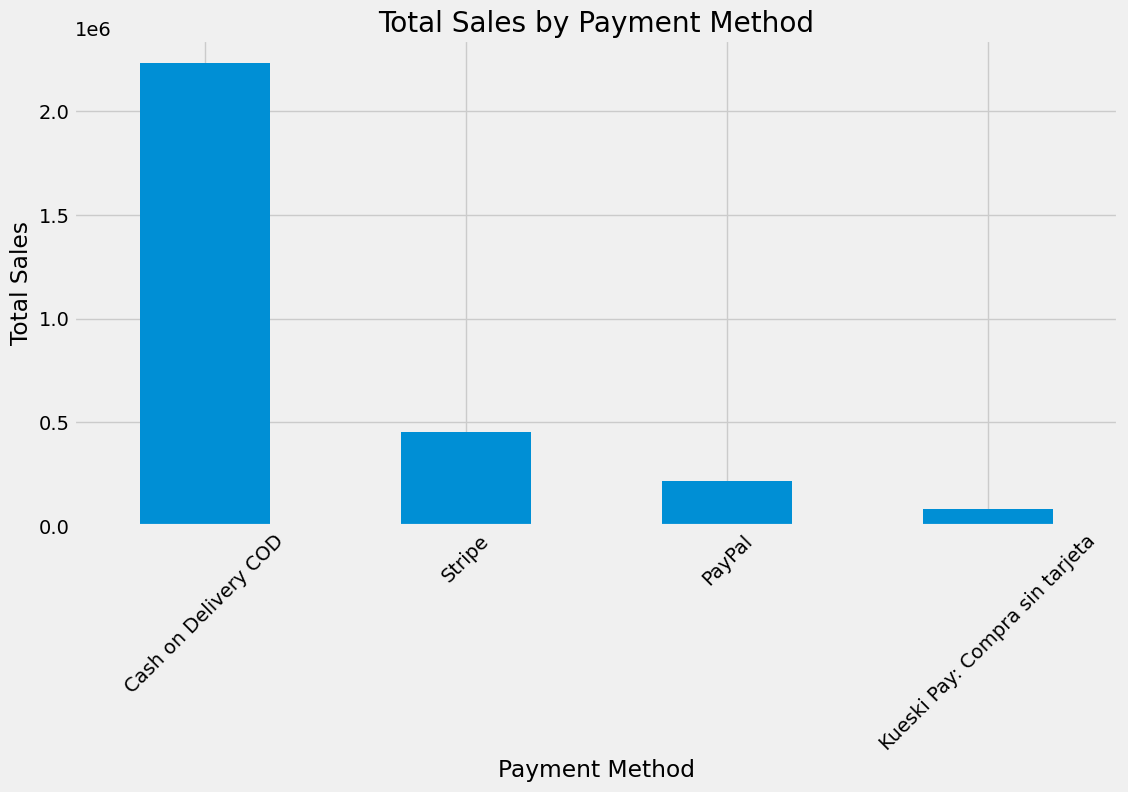

In [78]:
# Aggregate total sales by payment method
payment_method_sales = df_orders.groupby('Payment Methods', observed=False)['Total'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
payment_method_sales.plot(kind='bar')
plt.title('Total Sales by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




### 18. Column formatting

In [79]:

# Convert column 'Created At' to datetime using strptime
df_orders['Created At'] = df_orders['Created At'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S%z').replace(tzinfo=None) if pd.notnull(x) else x
)

# Convert to datetime from pandas
df_orders['Created At'] = pd.to_datetime(df_orders['Created At'])

# Exctract the date
df_orders['New_Date'] = df_orders['Created At'].dt.date

### 19. Export data to a PostgreSQL Database


In [80]:
#Connect to PostgreSQL and Insert Data

# PostgreSQL database credentials
db_user = '*****'
db_password = '*****'
db_host = 'localhost'  # or your database host
db_port = '5432'  # or your database port
db_name = '******'

# Define mapping of DataFrame columns to PostgreSQL data types
dtype_mapping = {
    'Order Number': types.Integer(),
    'Customer Name': types.String(length=255),
    'Customer Email': types.String(length=255),
    'Financial Status': types.String(length=50),
    'Paid At':  types.Date(),
    'Fulfillment Status': types.String(length=50),
    'Currency': types.String(length=10),
    'Subtotal': types.Numeric(precision=10, scale=2),
    'Shipping': types.Numeric(precision=10, scale=2),
    'Taxes': types.Numeric(precision=10, scale=2),
    'Total': types.Numeric(precision=10, scale=2),
    'Shipping Method': types.String(length=255),
    'Created At': types.Date(),
    'Lineitem Quantity': types.Integer(),
    'Lineitem Name': types.String(length=255),
    'Lineitem Price': types.Numeric(precision=10, scale=2),
    'Lineitem SKU': types.String(length=50),
    'Shipping City': types.String(length=255),
    'Shipping Province': types.String(length=255),
    'Payment Methods': types.String(length=255),  # If this is a list, consider normalizing it
    'New_Date': types.Date,
    'cancel_reason': types.String(length=255),
    'current_total_discounts': types.Numeric(precision=10, scale=2),
    'Unique Total': types.Numeric(precision=10, scale=2),
    'Unique Net Total': types.Numeric(precision=10, scale=2),
}

# Create SQLAlchemy engine to connect to PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Connect to PostgreSQL and delete existing data, comment this block when you want to actually append new data and not deleting the actual.
with engine.connect() as connection:
    try:
        delete_statement = text("DELETE FROM shopify_sales_data;")
        result = connection.execute(delete_statement)
        print(f"Deleted {result.rowcount} rows from shopify_sales_data.")
        
        # Explicitly commit the transaction
        connection.commit()
        
        print("Transaction committed.")
    except Exception as e:
        print(f"Error during delete operation: {str(e)}")
        # Rollback in case of error
        connection.rollback()

# Save DataFrame to PostgreSQL
try:
    df_orders.to_sql('shopify_sales_data', engine, if_exists='append', index=False, dtype=dtype_mapping)
    print("Data saved to PostgreSQL database successfully!")
except Exception as e:
    print(f"Error saving data to PostgreSQL: {str(e)}")

# Save to CSV
df_orders.to_csv('shopify_orders_2024_cleaned.csv', index=False, encoding= 'utf-8-sig')
print("Data retrieved and saved to 'shopify_orders_2024_cleaned.csv")

Deleted 4364 rows from shopify_sales_data.
Transaction committed.
Data saved to PostgreSQL database successfully!
Data retrieved and saved to 'shopify_orders_2024_cleaned.csv


### 20. Using the Meta Marketing API to Retrieve the Facebook/Instagram ads data

In [34]:
from facebook_business.adobjects.adaccount import AdAccount
from facebook_business.adobjects.adsinsights import AdsInsights
from facebook_business.api import FacebookAdsApi
from facebook_business.adobjects.adreportrun import AdReportRun
import time


access_token = 'put your access token here'
ad_account_id = 'put your ad account id here'
app_secret = 'put your app secret here'
app_id = 'put your app id here'

# Initialize the Facebook API
FacebookAdsApi.init(access_token=access_token)

ad_account = AdAccount(ad_account_id)

# Define minimal fields to retrieve
fields = [
    'actions',
    'action_values',
]


# Define parameters
params = {
    'time_range': {'since':'2022-01-01','until':'2024-08-15'},
    # 'date_preset': 'yesterday',
    'level': 'ad',  # Choose the level: campaign, adset, or ad
    'time_increment': 1,  # Obtener datos diarios
    'action_report_time': 'conversion',
}

# Create and start an async job to import high volume data
async_job = ad_account.get_insights_async(params=params, fields=fields)
job_id = async_job[AdReportRun.Field.id]
print(f"Job ID: {job_id}")


Job ID: 883297450336448


### 21. Check Job Status

In [35]:
# Function to check the status of the job
def check_job_status(job_id):
    async_job = AdReportRun(job_id)
    while True:
        job_status = async_job.api_get(fields=[AdReportRun.Field.async_status])[AdReportRun.Field.async_status]
        print(f"Job Status: {job_status}")
        if job_status == 'Job Completed':
            break
        elif job_status == 'Job Failed':
            raise Exception("Job Failed")
        time.sleep(10)  # Wait for 10 seconds before checking again

check_job_status(job_id)

Job Status: Job Not Started
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: Job Running
Job Status: 

### 22. Retrieve and Process Data

In [36]:
# Retrieve the results once the job is complete
def get_insights_data(job_id):
    async_job = AdReportRun(job_id)
    insights = async_job.get_insights()
    data = [insight.export_all_data() for insight in insights]
    return pd.DataFrame(data)

df = get_insights_data(job_id)

### 23. Extract Specific Values from Nested Fields

In [37]:
# Function to extract specific values from nested fields
def extract_specific_value(nested_field, value_type):
    if nested_field is not None:
        if isinstance(nested_field, list):
            for item in nested_field:
                if item['action_type'] == value_type:
                    return item['value']
        elif isinstance(nested_field, dict):
            if nested_field['action_type'] == value_type:
                return nested_field['value']
    return 0

# Extract specific values and create new columns

df['view_content'] = df['actions'].apply(lambda x: extract_specific_value(x, 'view_content'))
df['Add_to_cart'] = df['actions'].apply(lambda x: extract_specific_value(x, 'offsite_conversion.fb_pixel_add_to_cart'))
df['initiate_checkout'] = df['actions'].apply(lambda x: extract_specific_value(x, 'offsite_conversion.fb_pixel_initiate_checkout'))
df['purchase'] = df['actions'].apply(lambda x: extract_specific_value(x, 'offsite_conversion.fb_pixel_purchase'))
df['conversion_value'] = df['action_values'].apply(lambda x: extract_specific_value(x, 'offsite_conversion.fb_pixel_purchase'))

# Save to CSV
df.to_csv('facebook_ads_data.csv', index=False)
print("Data retrieved and saved to 'facebook_ads_data.csv'")

Data retrieved and saved to 'facebook_ads_data.csv'


### 24.  Select relevant columns

In [38]:
# Select relevant columns
columns_to_keep = [
        'date_start', 'date_stop', 'view_content', 'Add_to_cart', 'initiate_checkout', 'purchase', 'conversion_value'
]

df = df[columns_to_keep]

pd.set_option('display.max_columns', None) # Display all columns
df.head() # Display the first few rows of the DataFrame

,date_start,date_stop,view_content,Add_to_cart,initiate_checkout,purchase,conversion_value
0,2022-05-16,2022-05-16,31,0,0,0,0
1,2022-05-16,2022-05-16,2,0,0,0,0
2,2022-05-16,2022-05-16,0,0,0,0,0
3,2022-05-16,2022-05-16,0,0,0,0,0
4,2022-05-17,2022-05-17,23,1,1,0,0


### 25. Data cleaning (Remove duplicates)

In [39]:
#Remove any duplicates in case there are some.
df = df.drop_duplicates() 
df.head()

,date_start,date_stop,view_content,Add_to_cart,initiate_checkout,purchase,conversion_value
0,2022-05-16,2022-05-16,31,0,0,0,0
1,2022-05-16,2022-05-16,2,0,0,0,0
2,2022-05-16,2022-05-16,0,0,0,0,0
4,2022-05-17,2022-05-17,23,1,1,0,0
5,2022-05-17,2022-05-17,18,4,2,0,0


### 26. Data cleaning (Find null values)

In [40]:
# Get column names and corresponding count of null values
null_columns = {}
for col in df.columns:
    null_count = df[col].isnull().sum()
    if null_count > 0:
        null_columns[col] = null_count
        
print("Columns with null values and their counts:")
print(null_columns) 

Columns with null values and their counts:
{}


### 27. Data cleaning (Convert null values to 0)

In [41]:
#Convert null values to 0

df = df.fillna(0)
#Check
null_columns = {}
for col in df.columns:
    null_count = df[col].isnull().sum()
    if null_count > 0:
        null_columns[col] = null_count
        
print("Columns with null values and their counts:")
print(null_columns)

Columns with null values and their counts:
{}


### 28. Save data into a CSV

In [42]:
# Save to CSV
df.to_csv('facebook_ads_data_cleaned.csv', header= df.columns, index=False, encoding= 'utf-8-sig')
print("Data retrieved and saved to 'facebook_ads_data_cleaned.csv")

Data retrieved and saved to 'facebook_ads_data_cleaned.csv


### 29. Export data to a PostgreSQL Database

In [43]:
#Connect to PostgreSQL and Insert Data

# PostgreSQL database credentials
db_user = '*****'
db_password = '******'
db_host = 'localhost'  # or your database host
db_port = '5432'  # or your database port
db_name = 'Shopify Sales'

# Define mapping of DataFrame columns to PostgreSQL data types
dtype_mapping = {
    'date_start': types.Date,
    'date_stop': types.Date,
    'view_content': types.Integer,
    'Add_to_cart': types.Integer,
    'initiate_checkout': types.Integer,
    'purchase': types.Integer,
    'conversion_value': types.Float(precision=2),
}

# Create SQLAlchemy engine to connect to PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Connect to PostgreSQL and delete existing data, comment this block when you want to actually append new data and not deleting the actual.
with engine.connect() as connection:
    try:
        delete_statement = text("DELETE FROM facebook_ads_data;")
        result = connection.execute(delete_statement)
        print(f"Deleted {result.rowcount} rows from facebook_ads_data.")
        
        # Explicitly commit the transaction
        connection.commit()
        
        print("Transaction committed.")
    except Exception as e:
        print(f"Error during delete operation: {str(e)}")
        # Rollback in case of error
        connection.rollback()

# Save DataFrame to PostgreSQL
try:
    df.to_sql('facebook_ads_data', engine, if_exists='append', index=False, dtype=dtype_mapping)
    print("Data saved to PostgreSQL database successfully!")
except Exception as e:
    print(f"Error saving data to PostgreSQL: {str(e)}")

Deleted 4381 rows from facebook_ads_data.
Transaction committed.
Data saved to PostgreSQL database successfully!
